In [131]:
#Libraries 
import os
import time
import math
import numpy as np
import pandas as pd
import scipy
import scipy.signal as spsg
from scipy import stats
from scipy.io import loadmat
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cityblock



random.seed(42)

### Reading Data

In [132]:
# Read the data
data_path= "C:/Users/diego/Desktop/phase_coherance_consciousness/data"

#Awake
data_LSD = os.path.join(data_path, "LSD_TS_FC.mat")
data_LSD = loadmat(data_LSD)
data_LSD = data_LSD["DataCorrel"].flatten()
LSDACAT = np.hstack([data_LSD[i][2] for i in range(data_LSD.shape[0])])
LSDPCAT = np.hstack([data_LSD[i][5] for i in range(data_LSD.shape[0])])

LSD_Signals = np.hstack((LSDACAT, LSDPCAT))
print(f"LSD concatenated signals: {LSD_Signals.shape} from {data_LSD.shape[0]} patients.")

LSD concatenated signals: (90, 6937) from 16 patients.


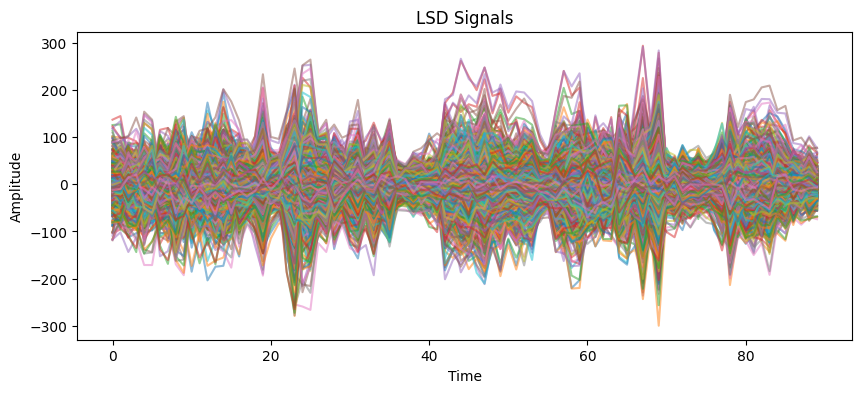

In [117]:
# Initial visualization of the Bold Signals (Time Series)
plt.figure(figsize=(10, 4))
plt.plot(LSD_Signals, alpha=0.5)
plt.title("LSD Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Extract Size and Features

In [133]:
#Number of Regions and Total Time
ROI,time_length = LSD_Signals.shape

# Loop over each region to extract the lenght of each signal.
Time_per_subj = np.zeros(ROI, dtype=int)
for i in range(ROI):
    Time_per_subj[i] = len(LSD_Signals[i])


print(f" Number of Regions (ROI): {ROI} \n Total Time: {time_length}")

 Number of Regions (ROI): 90 
 Total Time: 6937


### Import the Connectoma 

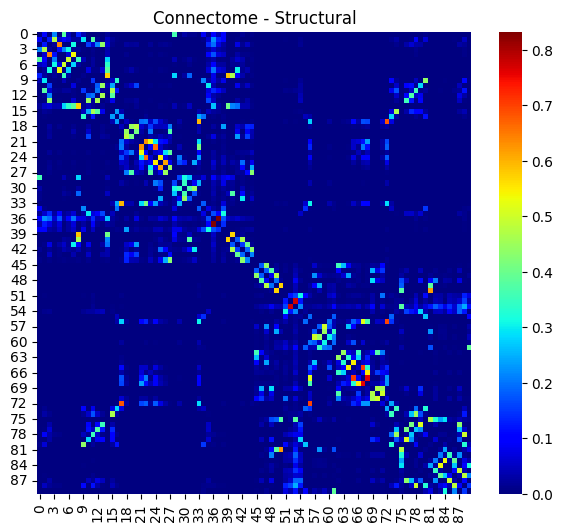

In [152]:
# Import the atlas
data_connectome = os.path.join(data_path, "./structural.mat")
CC = loadmat(data_connectome)['A']

# Plot it
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(CC, cmap='jet',cbar=True, ax=ax)
ax.set_title(f"Connectome - Structural")
plt.show()

In [141]:
np.info(Connectome)

class:  ndarray
shape:  (90, 90)
strides:  (8, 720)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x1a36cc20030
byteorder:  little
byteswap:  False
type: float64


### Preprocess Functions 

In [142]:
# Function to apply a Butterworth bandpass filter to a time series.
# It is particularly useful for removing noise and smoothing the signal in the specified frequency range.
def butterworth_filtering(ts):
    """
    Apply a Butterworth bandpass filter to the input time series `ts`.

    Parameters:
    ts : array-like
        The input time series (1D or 2D array).
        
    Returns:
    filtered_ts : array-like
        The filtered time series, same shape as input.
        
    Notes:
    - The filter settings are dependent on the experimental setup (TR = 2.4 seconds).
    - A 3rd-order Butterworth bandpass filter is applied with cutoff frequencies of 0.01 and 0.2 times the Nyquist frequency.
    - The Nyquist frequency is determined by the repetition time (TR = 2.4s).
    """
    # Parameters
    n_order = 3  # Filter order
    TR = 2.4  # Repetition time (in seconds, relevant for fMRI experiments)
    Nyquist_freq = 0.5 / TR  # Nyquist frequency (half the sampling rate)
    low_f = 0.01 / Nyquist_freq  # Low cutoff frequency (fraction of Nyquist)
    high_f = 0.2 / Nyquist_freq  # High cutoff frequency (fraction of Nyquist)
    
    # Design the Butterworth bandpass filter
    b, a = spsg.iirfilter(n_order, (low_f, high_f), btype='bandpass', ftype='butter', output='ba')
    
    # Apply the filter to the time series using zero-phase filtering
    filtered_ts = spsg.filtfilt(b, a, ts, axis=-1)
    
    return filtered_ts

In [143]:
def adif(a, b):
    """
    Calculate the angular difference between two angles `a` and `b` in radians.

    Parameters:
    a, b : float
        The input angles in radians.
        
    Returns:
    float
        The angular difference between the two angles, always in the range [0, π]. The smallest angel diffence.
    """
    if abs(a - b) > math.pi:
        return 2 * math.pi - abs(a - b)
    else:
        return abs(a - b)


### Phase difference between each pair of regions

In [144]:
timeseriedata = np.empty((ROI, time_length))
Amplitude = np.empty((ROI, time_length))
Phases = np.empty((ROI, time_length))

# For each Region we preprocess the signal to exctract instantaneous phase
for i in range(ROI):

    #Extract the signal
    ts = LSD_Signals[i,:]

    # Normalize the signal using Z-score
    ts_z = stats.zscore(ts)

    # Subtract the mean
    ts_z = ts_z-np.mean(ts_z,axis=0)

    # Apply the Butterworth filter 
    #ts_filtered = butterworth_filtering(ts_z)
    ts_filtered = ts_z
    
    timeseriedata[i, :] = ts_filtered

    # Perform the Hilbert transform
    hilbert_tf = spsg.hilbert(ts_z, axis=-1)
    Amplitude[i, :] = np.abs(hilbert_tf)

    # Instantaneous phase
    Phases[i, :] = np.angle(hilbert_tf)

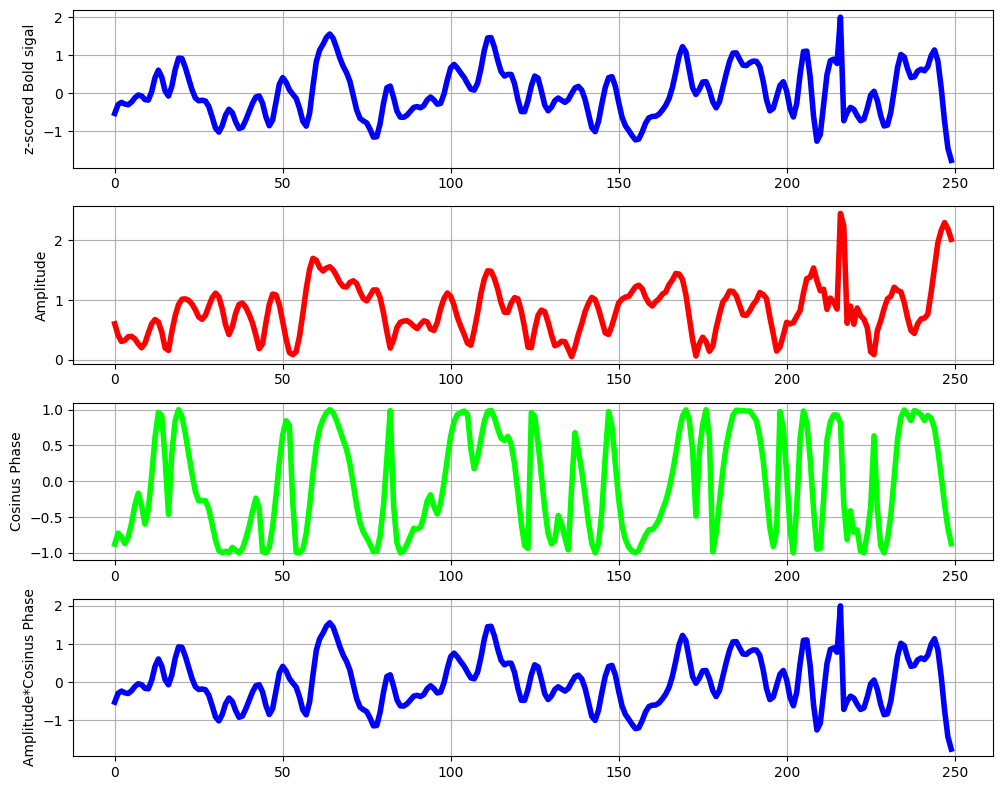

In [145]:
def createfigure(Y1, Y2, Y3, Y4):
    """
    Creates a figure with 4 vertical subplots to visualize:
    - Y1: Z-scored signal (e.g., bold)
    - Y2: Amplitude
    - Y3: Cosine of the phase
    - Y4: Amplitude * cosine of the phase
    """

    fig, axs = plt.subplots(4, 1, figsize=(10, 8))
    
    axs[0].plot(Y1, linewidth=4, color=[0, 0, 1])
    axs[0].set_ylabel('z-scored Bold sigal')
    axs[0].grid(True) 
    
    axs[1].plot(Y2, linewidth=4, color=[1, 0, 0])
    axs[1].set_ylabel('Amplitude')
    axs[1].grid(True)
    
    
    axs[2].plot(Y3, linewidth=4, color=[0, 1, 0])
    axs[2].set_ylabel('Cosinus Phase')
    axs[2].grid(True)
    
    axs[3].plot(Y4, linewidth=4, color=[0, 0, 1])
    axs[3].set_ylabel('Amplitude*Cosinus Phase')
    axs[3].grid(True)
    
    plt.tight_layout()
    plt.show()

#We replicate a signal
Y1 = timeseriedata[0, :250]
Y2 = Amplitude[0, :250]
Y3 = np.cos(Phases[0, :250])
Y4 = Amplitude[0, :250] * np.cos(Phases[0, :250])
createfigure(Y1, Y2, Y3, Y4)

### Vectorized Computation for each time instant 

In [146]:
# Number of pairs (only the lower part of the matrix): ROI*(ROI-1)/2
row_idx, col_idx = np.tril_indices(ROI, k=-1)
sorted_indices = np.lexsort((row_idx, col_idx))
lower_indices_corrected = (row_idx[sorted_indices], col_idx[sorted_indices])


num_pairs = len(lower_indices_corrected[0])
pattern = np.empty((num_pairs, time_length))


# Vectorized computation for each time instant
for t in range(time_length):
    patt = np.empty((ROI, ROI))
    for i in range(ROI):
        for j in range(i):
            patt[i,j] = np.cos(adif(Phases[i,t],Phases[j,t]))
    pattern[:, t] = patt[lower_indices_corrected]
    

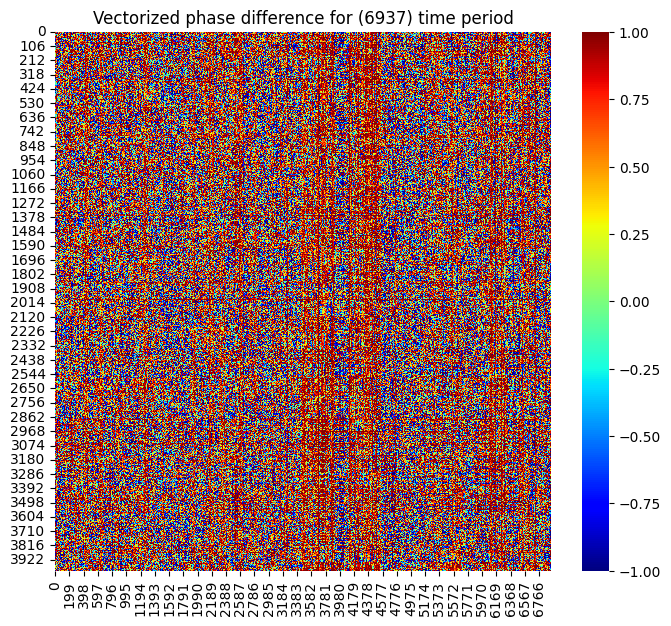

In [147]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(pattern, cmap='jet', vmin=-1, vmax=1, cbar=True, ax=ax)
ax.set_title(f"Vectorized phase difference for ({time_length}) time period")
plt.show()

### Remove Empty Images

In [148]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import zscore


all_pattern2D = pattern.T


# Empty Images
print("Size before removing empty images:", all_pattern2D.shape)
good_pattern = np.sum(np.abs(all_pattern2D), axis=1) > 0
all_pattern2D = all_pattern2D[good_pattern, :]  
print("Size after removing empty images:", all_pattern2D.shape)

# Outliers
D = squareform(pdist(all_pattern2D, metric='cityblock'))  
D = zscore(np.mean(D, axis=1))  
good_pattern = D < 3 
all_pattern2D = all_pattern2D[good_pattern, :]  
print("Size after removing outliers:", all_pattern2D.shape)


Size before removing empty images: (6937, 4005)
Size after removing empty images: (6937, 4005)
Size after removing outliers: (6937, 4005)


### K-Means

In [150]:
# Parameters
opts = {"max_iter": 200}
Kmeans_results = {} 
aux_data = pattern.T 

# Manhattan distance
def compute_manhattan_distance(data_point, centroids, cluster_labels):
    return cityblock(data_point, centroids[cluster_labels])

# KMeans clustering for each k (currently just k=5)
for k in [5]:
    kmeans = KMeans(n_clusters=k, max_iter=opts["max_iter"], n_init=1, random_state=0)
    kmeans.fit(aux_data)

    cidx_Pha = kmeans.labels_
    ctrs_Pha = kmeans.cluster_centers_

    #Manhattan distances
    sum_D_Pha = np.sum([compute_manhattan_distance(aux_data[i], ctrs_Pha, cidx_Pha[i]) for i in range(aux_data.shape[0])])

    Kmeans_results[k] = {
        "cidx_Pha": cidx_Pha,
        "ctrs_Pha": ctrs_Pha,
        "sum_D_Pha": sum_D_Pha
    }

# Verify Dimensions
print(f"cidx_Pha shape: {Kmeans_results[5]['cidx_Pha'].shape}")
print(f"ctrs_Pha shape: {Kmeans_results[5]['ctrs_Pha'].shape}")
print(f"sum_D_Pha: {Kmeans_results[5]['sum_D_Pha']}")


cidx_Pha shape: (6937,)
ctrs_Pha shape: (5, 4005)
sum_D_Pha: 15219263.012145309


### Visualization

In [183]:
# Number of clustering states
n_state = 5
cidx = Kmeans_results[n_state]['cidx_Pha']  # Cluster labels per time point
L = cidx.shape[0]  # Total number of time points
T_shift = 9  # Time shift parameter

# Reordering the structural connectivity matrix
id_aal = np.arange(1, 91)  # IDs from 1 to 90
id_deco = np.concatenate([np.linspace(1, 89, 45, dtype=int), np.linspace(2, 90, 45, dtype=int)[::-1]])
deco_to_aal_mapping = np.searchsorted(id_aal, id_deco)  # Mapping from id_deco to id_aal
CC2 = CC[np.ix_(deco_to_aal_mapping, deco_to_aal_mapping)]  # Reorder the connectivity matrix

# Flatten the connectome matrix for correlation analysis
VC = CC.flatten().astype(np.float64)

# Compute CCA (correlations between centroids and connectome)
CCA = np.zeros(n_state)
for i in range(n_state):
    centroid_vector = Kmeans_results[n_state]['ctrs_Pha'][i, :]
    QQ = squareform(centroid_vector)  # Convert to symmetric matrix
    VA = QQ.flatten()
    MC = np.corrcoef(VA, VC)  # Correlation with the connectome
    CCA[i] = MC[0, 1]

# Sorting states based on correlation values
B = np.sort(CCA)
I = np.argsort(CCA)

# Compute state rates
rate = np.zeros(n_state)
ratea = np.zeros(n_state)
rateb = np.zeros(n_state)

denom = L - 2 * T_shift  # Normalization factor

for bst in range(n_state):
    rate[bst]  = np.sum(cidx == I[bst]) / denom
    ratea[bst] = np.sum(cidx[:3465] == I[bst]) / denom
    rateb[bst] = np.sum(cidx[3466:6919] == I[bst]) / denom

# Compute cumulative time spent per subject
times_matrix_k = np.zeros((16, 2))
times_matrix_p = np.zeros((16, 2))

for i in range(16):
    size_value_k = data_LSD[i]['LSD_TS'].shape[1]
    size_value_p = data_LSD[i]['PCB_TS'].shape[1]
    times_matrix_k[i, 0] = size_value_k
    times_matrix_p[i, 0] = size_value_p
    times_matrix_k[i, 1] = size_value_k if i == 0 else times_matrix_k[i-1, 1] + size_value_k
    times_matrix_p[i, 1] = size_value_p if i == 0 else times_matrix_p[i-1, 1] + size_value_p

# Compute state rates per segment
scratekt = np.zeros((15, n_state))
scratektp = np.zeros((15, n_state))

for s in range(15):
    for j in range(n_state):
        if s == 0:
            scratekt[s, j] = np.sum(cidx[:int(times_matrix_k[s, 1])] == I[j]) / times_matrix_k[0, 1]
            scratektp[s, j] = np.sum(cidx[3465:3465 + int(times_matrix_p[s, 1])] == I[j]) / times_matrix_p[0, 1]
        else:
            scratekt[s, j] = np.sum(cidx[int(times_matrix_k[s-1, 1]):int(times_matrix_k[s, 1])] == I[j]) / times_matrix_k[0, 1]
            scratektp[s, j] = np.sum(cidx[3465 + int(times_matrix_p[s-1, 1]): 3465 + int(times_matrix_p[s, 1]) - 20] == I[j]) / times_matrix_p[0, 1]

# Prepare group comparison matrix
grp = np.concatenate([np.zeros(15), np.ones(15)])
CH = np.zeros((30, n_state))

for i in range(n_state):
    CH[:, i] = np.concatenate([scratekt[:, i], scratektp[:, i]])


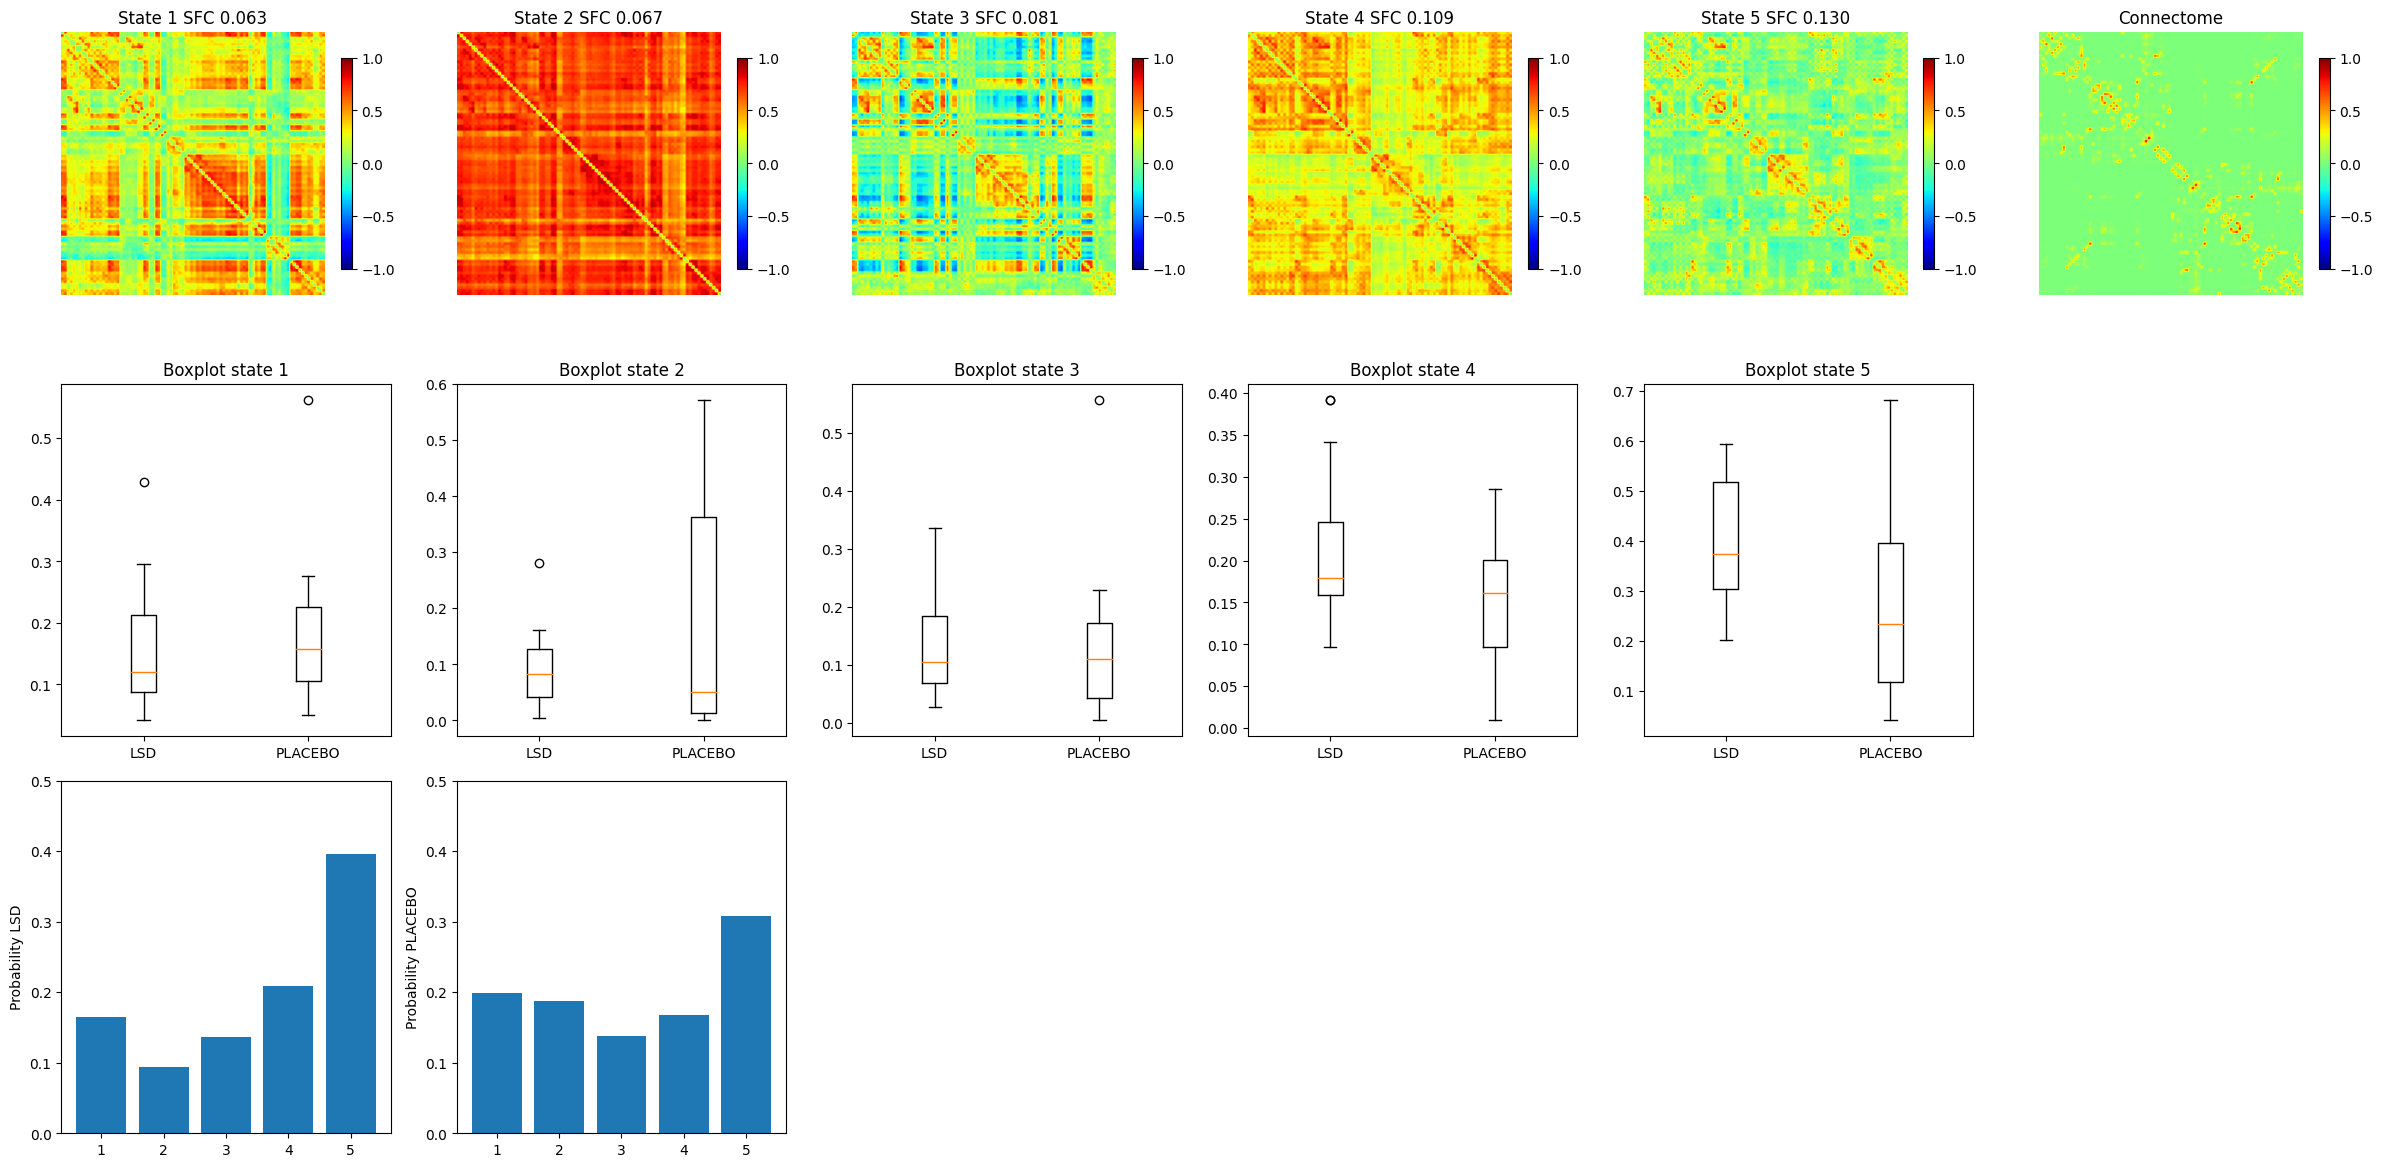

In [185]:
fig, axs = plt.subplots(3, n_state + 1, figsize=(4*(n_state+1), 12))

#Correlation matrices of each state
for i in range(n_state):
    QQ = squareform(Kmeans_results[n_state]['ctrs_Pha'][I[i], :])  # Convert to symmetric matrix
    im = axs[0, i].imshow(QQ, vmin=-1, vmax=1, cmap='jet')
    axs[0, i].set_title(f"State {i+1} SFC {B[i]:.3f}")
    axs[0, i].axis("off")
    plt.colorbar(im, ax=axs[0, i], shrink=0.6)

#Connectome matrix
axs[0, n_state].imshow(CC, vmin=-1, vmax=1, cmap='jet')
axs[0, n_state].set_title("Connectome")
axs[0, n_state].axis("off")
plt.colorbar(im, ax=axs[0, n_state], shrink=0.6)

#Boxplots for each state
for i in range(n_state):
    axs[1, i].boxplot([CH[:15, i], CH[15:, i]], labels=["LSD", "PLACEBO"])
    axs[1, i].set_title(f"Boxplot state {i+1}")
axs[1, n_state].axis('off')

#Bar plots for state probabilities in LSD and PLACEBO
axs[2, 0].bar(np.arange(1, n_state+1), ratea/np.sum(ratea))
axs[2, 0].set_ylim([0, 0.5])
axs[2, 0].set_ylabel('Probability LSD')

axs[2, 1].bar(np.arange(1, n_state+1), rateb/np.sum(rateb))
axs[2, 1].set_ylim([0, 0.5])
axs[2, 1].set_ylabel('Probability PLACEBO')

# Hide remaining columns
for j in range(2, n_state+1):
    axs[2, j].axis('off')

plt.tight_layout()
plt.show()


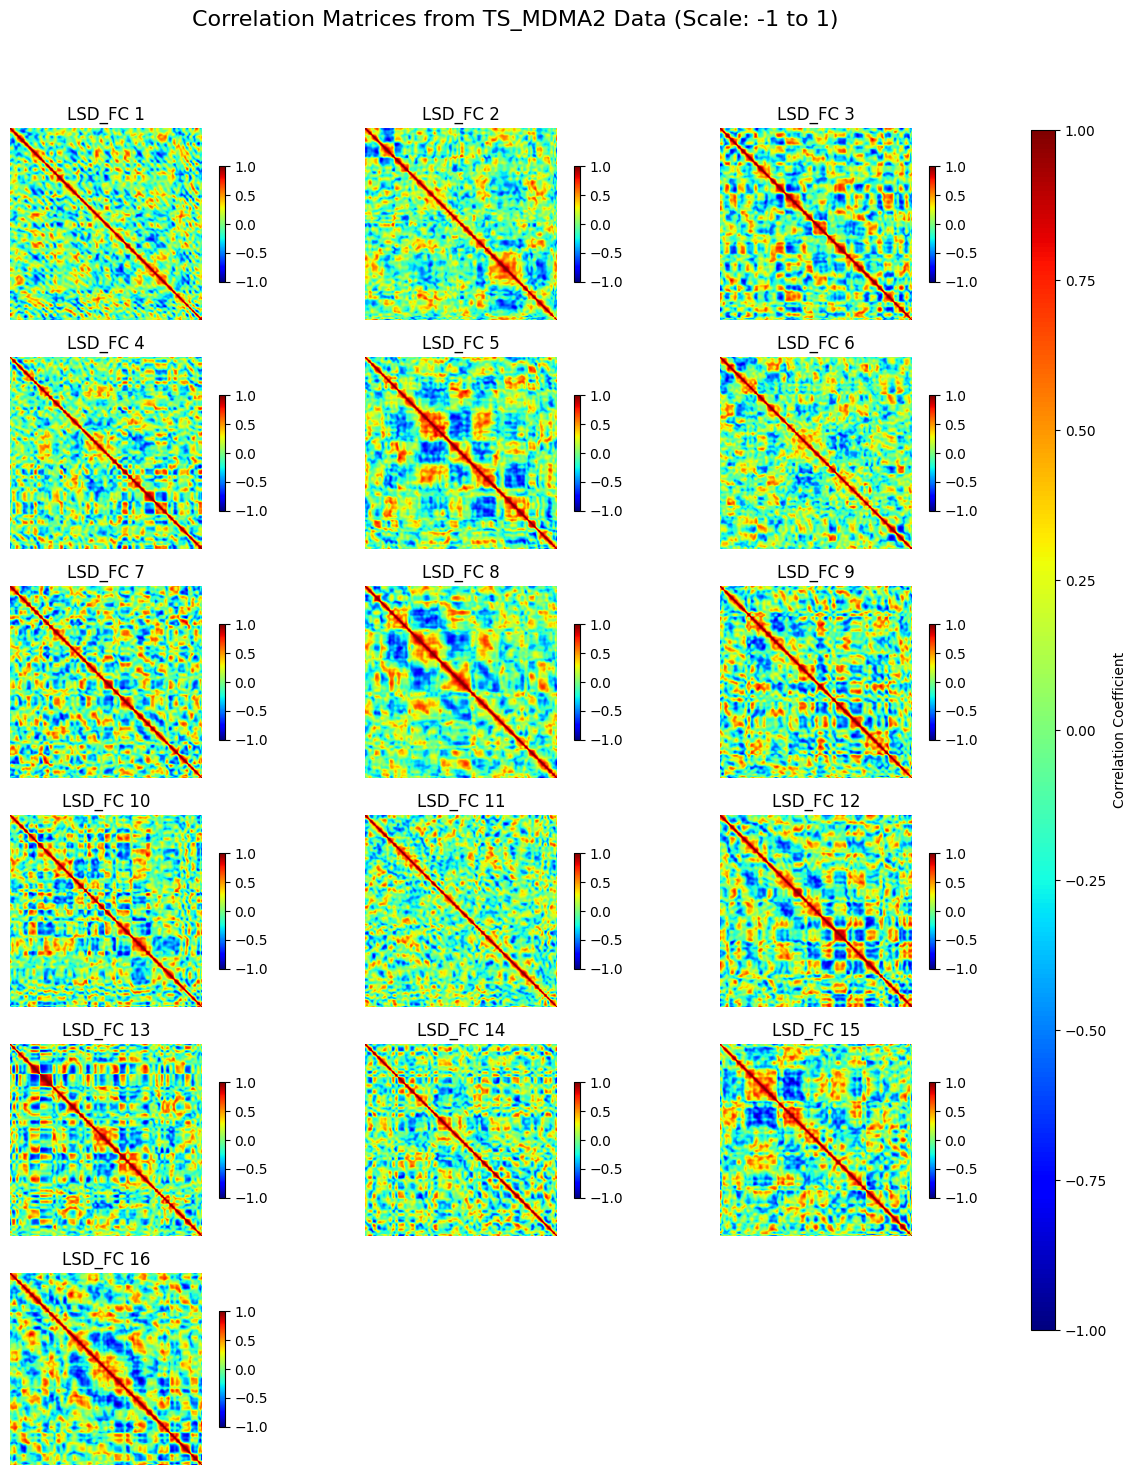

In [190]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with a specified size (Matlab's [100 100 1200 1500] is roughly 12x15 inches)
fig, axs = plt.subplots(6, 3, figsize=(12, 15))  # 6 rows x 3 columns = 18 subplots

# Loop through all 16 plots (Matlab: for k = 1:16)
for k in range(16):
    # Compute the correlation matrix of the LSD_TS data (transpose to correlate channels)
    # Assumes DataCorrel[k]['LSD_TS'] is a 2D numpy array.
    corr_mat = np.corrcoef(data_LSD[k]['LSD_TS'].T)
    
    # Calculate subplot position using a 6x3 grid
    row = k // 3  # integer division
    col = k % 3
    ax = axs[row, col]
    
    # Display the correlation matrix with fixed color limits between -1 and 1 and using the 'jet' colormap
    im = ax.imshow(corr_mat, vmin=-1, vmax=1, cmap='jet')
    ax.axis("off")
    plt.colorbar(im, ax=ax, shrink=0.6)

    
    # Add a title to each subplot (Matlab: title(['LSD_FC ' num2str(k)]))
    ax.set_title(f"LSD_FC {k+1}")  # k+1 to match Matlab numbering

# Hide any unused subplots (since 6x3 creates 18 axes, but we use only 16)
for k in range(16, 18):
    row = k // 3
    col = k % 3
    axs[row, col].axis('off')

# Set a common colormap for the entire figure (already set per image, but can enforce a global setting)
plt.set_cmap('jet')

# Add a common title for the entire figure (Matlab: sgtitle)
fig.suptitle('Correlation Matrices from TS_MDMA2 Data (Scale: -1 to 1)', fontsize=16)

# Adjust the layout to make it tighter (leave space for the global colorbar)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

# OPTIONAL: Add a single, larger global colorbar for the entire figure
# Create an axes on the right side for the colorbar.
cbar_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
fig.colorbar(im, cax=cbar_ax, label='Correlation Coefficient')

plt.show()


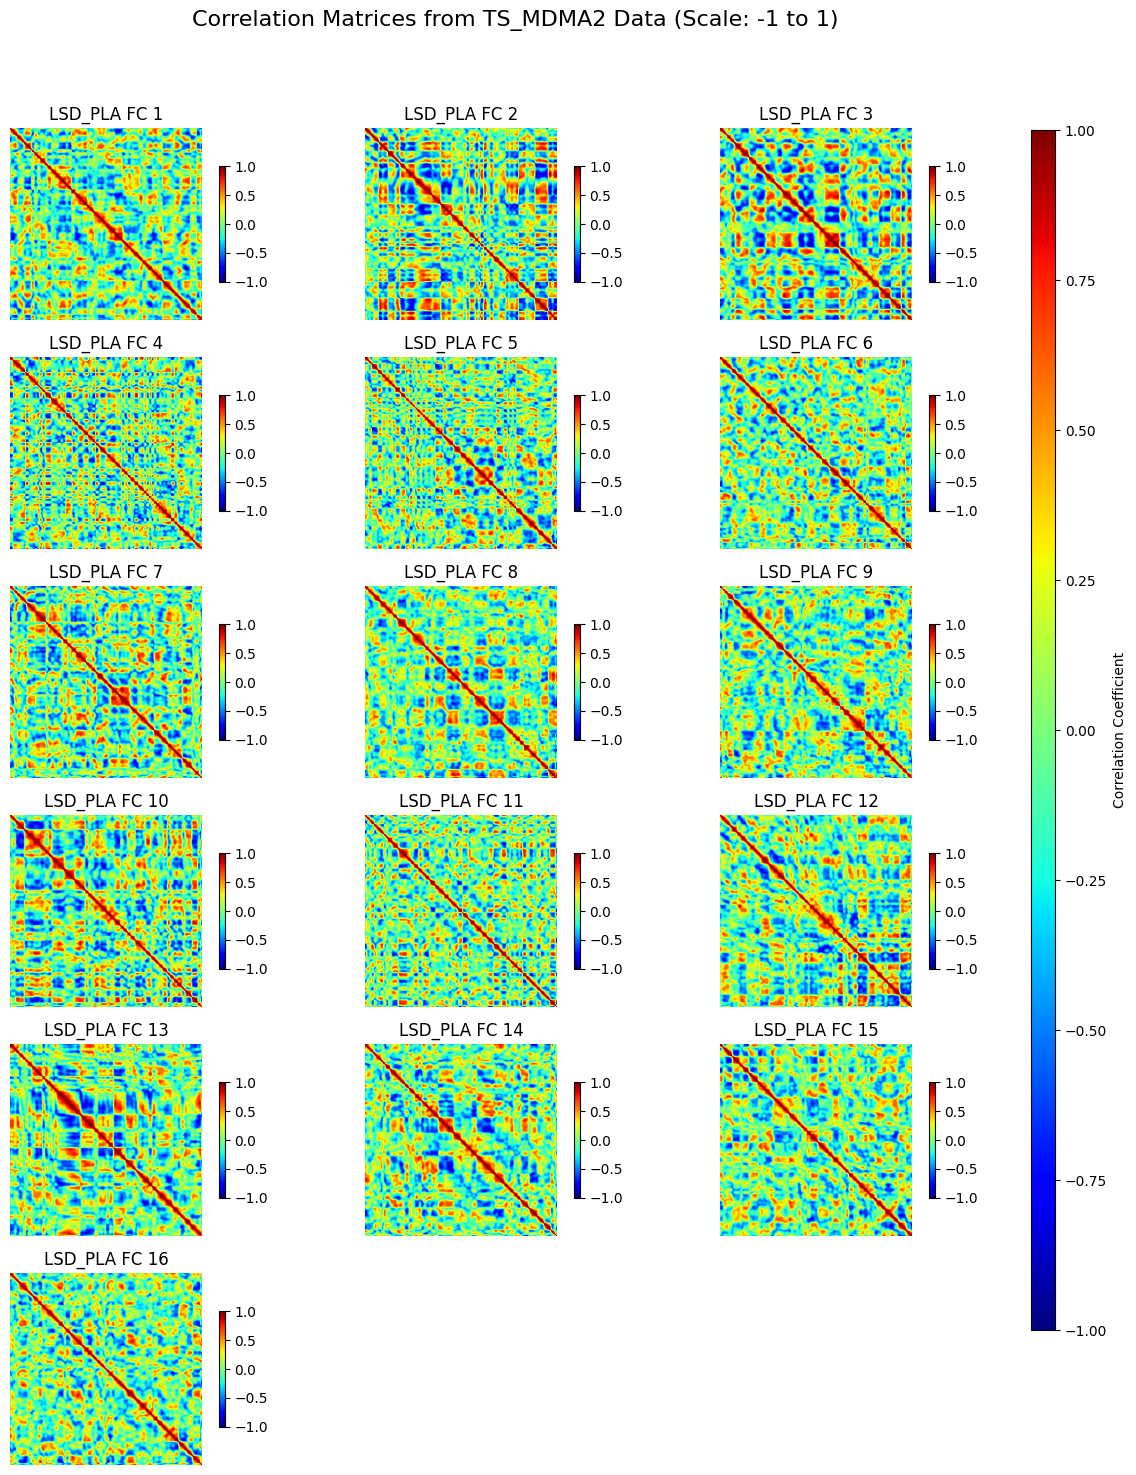

In [191]:
# Create a new figure for PCB_TS correlation matrices
fig2, axs2 = plt.subplots(6, 3, figsize=(12, 15))  # 6 rows x 3 columns

# Loop through all 16 plots (for k = 1:16 in Matlab)
for k in range(16):
    # Compute the correlation matrix for PCB_TS data (transpose to correlate channels)
    corr_mat = np.corrcoef(data_LSD[k]['PCB_TS'].T)
    
    # Determine the subplot position within the 6x3 grid
    row = k // 3
    col = k % 3
    ax = axs2[row, col]
    
    # Display the correlation matrix with fixed color limits and using the 'jet' colormap
    im = ax.imshow(corr_mat, vmin=-1, vmax=1, cmap='jet')
    ax.axis("off")
    plt.colorbar(im, ax=ax, shrink=0.6)
    
    # Add a title to each subplot (Matlab: title(['LSD_PLA FC ' num2str(k)]))
    ax.set_title(f"LSD_PLA FC {k+1}")

# Hide any unused subplots (18 total axes in a 6x3 grid, only 16 used)
for k in range(16, 18):
    row = k // 3
    col = k % 3
    axs2[row, col].axis('off')

# Set a common colormap for the figure
plt.set_cmap('jet')

# Add a common title for the entire figure (Matlab: sgtitle)
fig2.suptitle('Correlation Matrices from TS_MDMA2 Data (Scale: -1 to 1)', fontsize=16)

# Adjust layout to be tight (reserve space for the global colorbar)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

# OPTIONAL: Add a single, larger global colorbar for the entire figure
cbar_ax2 = fig2.add_axes([0.93, 0.1, 0.02, 0.8])
fig2.colorbar(im, cax=cbar_ax2, label='Correlation Coefficient')

plt.show()
